In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

plt.style.use("fivethirtyeight")
import plotly.express as px
import plotly.graph_objects as go

pd.options.display.max_columns = 999
%load_ext nb_black

project_root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
file_path = os.path.join(project_root_dir, "data")
%config Completer.use_jedi = False
# function for loading data
def load_data(filename, file_path=file_path):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path)

<IPython.core.display.Javascript object>

In [2]:
batting = load_data("batting.csv")
batting.head()

,POS,PLAYER,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,50,4s,6s,Nationality,Player Link,Team,Season
0,1,David Warner,12,12,2,692,100,69.20,481,143.86,1,8,57,21,Overseas,https://www.iplt20.com/teams/sunrisers-hyderab...,Sunrisers Hyderabad,2019
1,2,KL Rahul,14,14,3,593,100,53.90,438,135.38,1,6,49,25,Indian,https://www.iplt20.com/teams/kings-xi-punjab/s...,Kings Xi Punjab,2019
2,3,Quinton de Kock,16,16,1,529,81,35.26,398,132.91,0,4,45,25,Overseas,https://www.iplt20.com/teams/mumbai-indians/sq...,Mumbai Indians,2019
3,4,Shikhar Dhawan,16,16,1,521,97,34.73,384,135.67,0,5,64,11,Indian,https://www.iplt20.com/teams/delhi-capitals/sq...,Delhi Capitals,2019
4,5,Andre Russell,14,13,4,510,80,56.66,249,204.81,0,4,31,52,Overseas,https://www.iplt20.com/teams/kolkata-knight-ri...,Kolkata Knight Riders,2019


<IPython.core.display.Javascript object>

In [3]:
batting = batting.drop(['PLAYER','POS','Player Link'], axis=1)
batting.head()

,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,50,4s,6s,Nationality,Team,Season
0,12,12,2,692,100,69.20,481,143.86,1,8,57,21,Overseas,Sunrisers Hyderabad,2019
1,14,14,3,593,100,53.90,438,135.38,1,6,49,25,Indian,Kings Xi Punjab,2019
2,16,16,1,529,81,35.26,398,132.91,0,4,45,25,Overseas,Mumbai Indians,2019
3,16,16,1,521,97,34.73,384,135.67,0,5,64,11,Indian,Delhi Capitals,2019
4,14,13,4,510,80,56.66,249,204.81,0,4,31,52,Overseas,Kolkata Knight Riders,2019


<IPython.core.display.Javascript object>

## Predicting Runs

In [4]:
# create a train and test set
train_set = batting[batting['Season'] != 2019]
test_set = batting[batting['Season']== 2019]

X_train = train_set.drop('Runs', axis=1)
y_train = train_set['Runs']

X_test = test_set.drop('Runs', axis=1)
y_test = test_set['Runs']

<IPython.core.display.Javascript object>

### Data Preprocessing 

In [5]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

<IPython.core.display.Javascript object>

In [6]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

<IPython.core.display.Javascript object>

In [7]:
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N/A"),
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)
num_preprocessing = make_pipeline(SimpleImputer())

preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing, cat_cols)]
)

<IPython.core.display.Javascript object>

In [8]:
# fit and transform the data
X_train_tr = preprocessing.fit_transform(X_train)
X_test_tr = preprocessing.transform(X_test)

<IPython.core.display.Javascript object>

In [9]:
# Get the list of categories generated by the one-hot-encoder
ohe_categories = preprocessing.named_transformers_["cat"]["onehotencoder"].categories_
# Create nice names for our one hot encoded features
new_ohe_features = [
    f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals
]
# Create a new list with all names of features
all_features = num_cols + new_ohe_features
# Create pandas dataframe
X_train_tr = pd.DataFrame(X_train_tr, columns=all_features)
X_test_tr = pd.DataFrame(X_test_tr, columns=all_features)

<IPython.core.display.Javascript object>

In [10]:
X_train_tr.head()

,Mat,Inns,NO,HS,Avg,BF,SR,100,50,4s,6s,Season,Nationality__Indian,Nationality__Overseas,Team__Chennai Super Kings,Team__Delhi Capitals,Team__Kings Xi Punjab,Team__Kolkata Knight Riders,Team__Mumbai Indians,Team__Nan,Team__Rajasthan Royals,Team__Royal Challengers Bangalore,Team__Sunrisers Hyderabad
0,17.0,17.0,3.0,84.0,52.50,516.0,142.44,0.0,8.0,64.0,28.0,2018.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,14.0,14.0,1.0,128.0,52.61,394.0,173.60,1.0,5.0,68.0,37.0,2018.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.0,14.0,2.0,95.0,54.91,416.0,158.41,0.0,6.0,66.0,32.0,2018.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,16.0,2.0,100.0,43.00,402.0,149.75,1.0,3.0,53.0,34.0,2018.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15.0,15.0,1.0,117.0,39.64,359.0,154.59,2.0,2.0,44.0,35.0,2018.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [11]:
X_train_tr.shape

(1100, 23)

<IPython.core.display.Javascript object>

In [12]:
X_test_tr.shape

(100, 23)

<IPython.core.display.Javascript object>

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
xgb = XGBRegressor(random_state=42)
scores = cross_val_score(xgb, X_train_tr, y_train)
scores

array([0.98549356, 0.99547427, 0.99139217, 0.99498979, 0.99386604])

<IPython.core.display.Javascript object>

In [14]:
scores.mean()

0.9922431649571027

<IPython.core.display.Javascript object>

In [15]:
scores = cross_val_score(xgb, X_train_tr, y_train, cv=10, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
rmse_scores

array([16.77000141, 27.39655885,  9.6202115 , 10.03722856, 10.13748523,
       14.80220325,  8.69489435,  7.97371026,  7.44950162,  9.39448175])

<IPython.core.display.Javascript object>

In [16]:
rmse_scores.mean()

12.227627677929298

<IPython.core.display.Javascript object>

We can see that on average the model is making an error of 12 runs which is not so bad. Let's try to predict some players runs.

In [17]:
pd.DataFrame(X_test_tr.iloc[1]).T

,Mat,Inns,NO,HS,Avg,BF,SR,100,50,4s,6s,Season,Nationality__Indian,Nationality__Overseas,Team__Chennai Super Kings,Team__Delhi Capitals,Team__Kings Xi Punjab,Team__Kolkata Knight Riders,Team__Mumbai Indians,Team__Nan,Team__Rajasthan Royals,Team__Royal Challengers Bangalore,Team__Sunrisers Hyderabad
1,14.0,14.0,3.0,100.0,53.9,438.0,135.38,1.0,6.0,49.0,25.0,2019.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [18]:
y_test.iloc[1]

593

<IPython.core.display.Javascript object>

In [19]:
xgb.fit(X_train_tr, y_train)
xgb.predict(pd.DataFrame(X_test_tr.iloc[1]).T)

array([615.2333], dtype=float32)

<IPython.core.display.Javascript object>

We can see that the model is overestimating little bit the runs of KL Rahul for the 2019 season. Let's understand how the predictions are being made.   

## Local Interpretation with SHAP

In [20]:
import shap
# load JS visualization code to notebook
shap.initjs()

<IPython.core.display.Javascript object>

In [21]:
# create a shap explainer object from the model
explainer = shap.TreeExplainer(xgb)
# compute the shap value for a player
shap_values = explainer.shap_values(pd.DataFrame(X_test_tr.iloc[1]).T)

<IPython.core.display.Javascript object>

In [22]:
shap_values.shape

(1, 23)

<IPython.core.display.Javascript object>

In [23]:
# check the unit of the output
explainer.model.tree_output

'raw_value'

<IPython.core.display.Javascript object>

In [24]:
# the expected value is the simply the mean of the all the runs
print(explainer.expected_value)
print(y_train.mean())

179.13434
179.13454545454545


<IPython.core.display.Javascript object>

In [25]:
# the predicted value of a observation is the sum of all the shap values(can be negative and positive) and the expected value
np.sum(shap_values)+ explainer.expected_value

615.23334

<IPython.core.display.Javascript object>

In [26]:
# difference between your model's prediction on the observation and the expected value
np.sum(shap_values) - explainer.expected_value

256.96466

<IPython.core.display.Javascript object>

This diiference of 257 is what shap is trying to explain. 

In [27]:
# plot the shap values for the player
print("Prediction for KL Rahul: ")
shap.force_plot(explainer.expected_value, shap_values, features= pd.DataFrame(X_test_tr.iloc[1]).T)

Prediction for KL Rahul: 


<IPython.core.display.Javascript object>

In [28]:
print("Prediction for David Warner: ")
shap_values = explainer.shap_values(pd.DataFrame(X_test_tr.iloc[0]).T)
shap.force_plot(explainer.expected_value, shap_values, features= pd.DataFrame(X_test_tr.iloc[1]).T)

Prediction for David Warner: 


<IPython.core.display.Javascript object>

In [29]:
y_test.iloc[0]

692

<IPython.core.display.Javascript object>

For both the observations, we can see that Number of Ball Faced is very important in predicting the runs.

## Global Interpretation with SHAP

In [30]:
# calculate shap values for all the observations
shap_values = explainer.shap_values(X_test_tr)

<IPython.core.display.Javascript object>

In [31]:
shap.force_plot(explainer.expected_value, shap_values, features= X_test_tr)

<IPython.core.display.Javascript object>

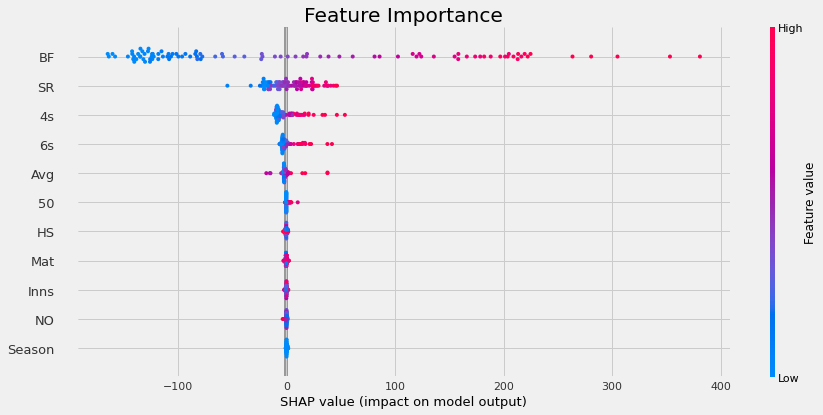

<IPython.core.display.Javascript object>

In [55]:
shap.summary_plot(shap_values, features= X_test_tr, max_display=11,plot_size=(13,6), show=False)
plt.title("Feature Importance")
plt.savefig('../images/batting_beeswarm.png')

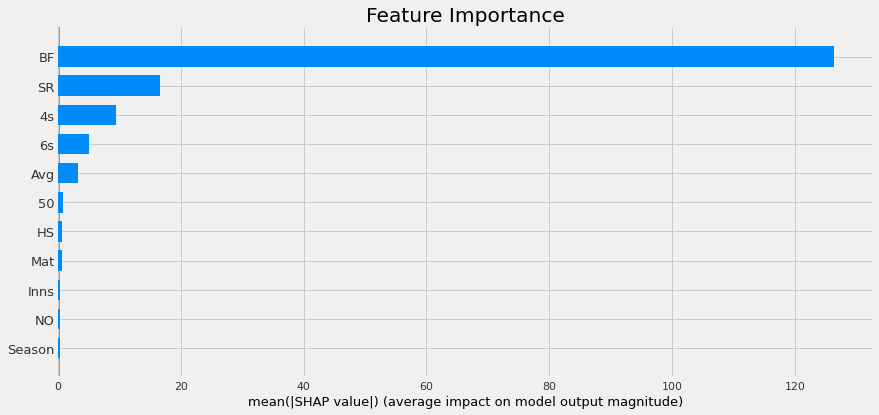

<IPython.core.display.Javascript object>

In [53]:
shap.summary_plot(shap_values, features= X_test_tr, plot_type='bar', max_display=11, plot_size=(13,6),show=False)
plt.title("Feature Importance")
plt.savefig("../images/batting_bar.png")

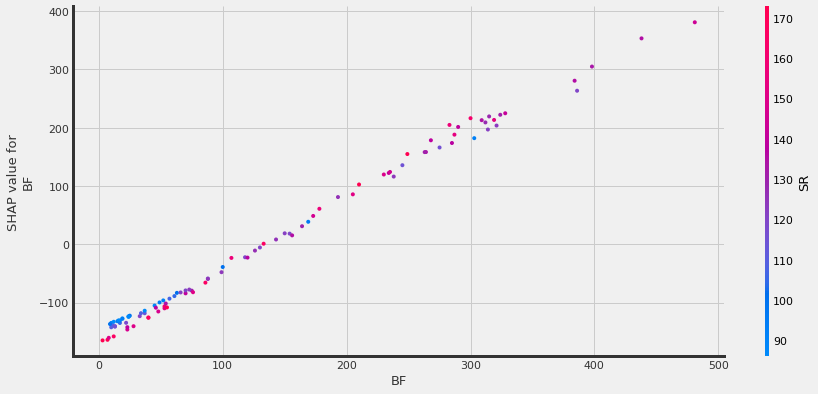

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=(13,6))
shap.dependence_plot("BF",shap_values,features= X_test_tr, show=False, ax=ax)
plt.savefig("../images/batting_bf.png")

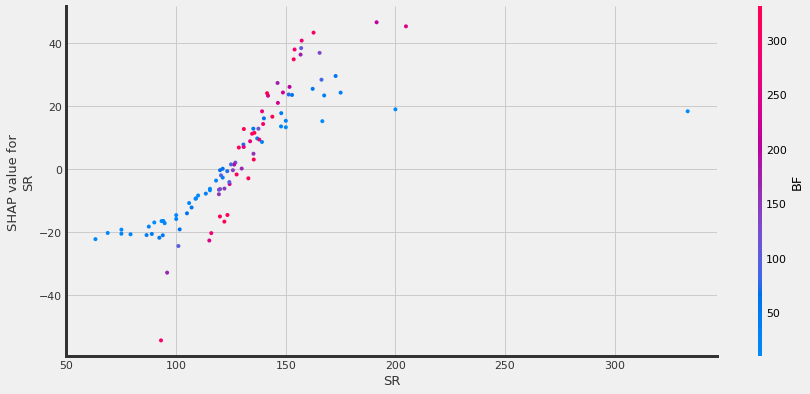

<IPython.core.display.Javascript object>

In [57]:
fig, ax = plt.subplots(figsize=(13,6))
shap.dependence_plot("SR",shap_values,features= X_test_tr, show=False, ax=ax)
plt.savefig("../images/batting_sr.png")

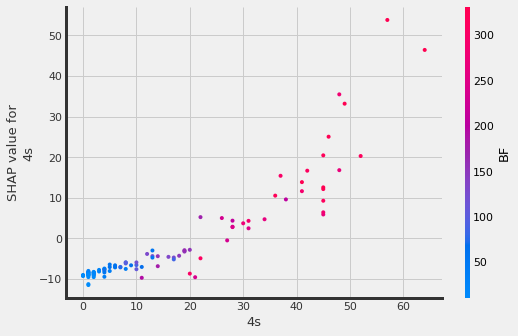

<IPython.core.display.Javascript object>

In [61]:
shap.dependence_plot("4s",shap_values,features= X_test_tr)

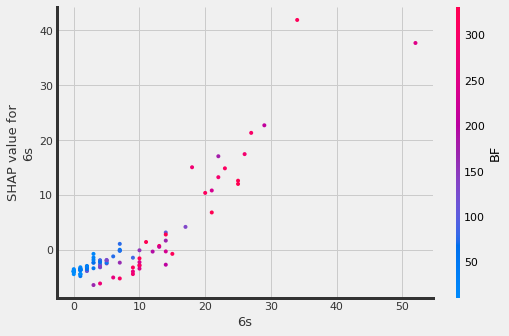

<IPython.core.display.Javascript object>

In [60]:
shap.dependence_plot("6s",shap_values,features= X_test_tr)

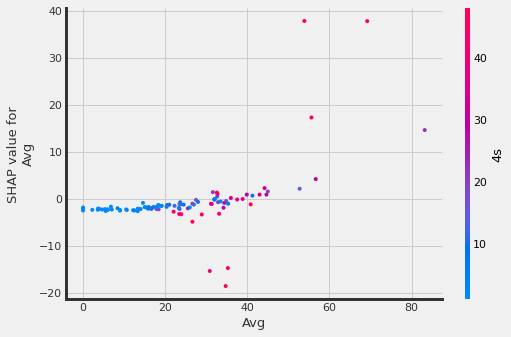

<IPython.core.display.Javascript object>

In [38]:
shap.dependence_plot("Avg",shap_values,features= X_test_tr)

### Feature Importances :

* BF - This is the most important feature in predicting how much runs a player will make and as the number of ball faced increases the number of runs also increases, so spending more time on the field is even much more important than having a very higher strike rate. 

* SR - Second most important feature is strike rate and having a higher strike rate is good. 

* 4s and 6s - Hitting 4s is slightly more important than hitting 6s in making runs in the long run. The reason cloud be hitting 4s is much easier than hitting 6s so most of the time players tends to have more 4s than 6s and when added together, in the long run 4s generate more runs. 

* Avg - Batting avg is also important but not as much as the above mentioned metrics. 

## Predicting Wickets

In [62]:
bowling = load_data("bowling.csv")
bowling.head()

,POS,PLAYER,Mat,Inns,Ov,Runs,Wkts,BBI,Avg,Econ,SR,4w,5w,Nationality,Player Link,Team,Dots,Maid,Season
0,1,Imran Tahir,17,17,64.2,431,26,0,16.57,6.69,14.84,2,0,Overseas,https://www.iplt20.com/teams/chennai-super-kin...,Chennai Super Kings,149.0,1.0,2019
1,2,Kagiso Rabada,12,12,47.0,368,25,0,14.72,7.82,11.28,2,0,Overseas,https://www.iplt20.com/teams/delhi-capitals/sq...,Delhi Capitals,113.0,0.0,2019
2,3,Deepak Chahar,17,17,64.3,482,22,0,21.90,7.47,17.59,0,0,Indian,https://www.iplt20.com/teams/chennai-super-kin...,Chennai Super Kings,190.0,2.0,2019
3,4,Shreyas Gopal,14,14,48.0,347,20,0,17.35,7.22,14.40,0,0,Indian,https://www.iplt20.com/teams/rajasthan-royals/...,Rajasthan Royals,107.0,1.0,2019
4,5,Jasprit Bumrah,16,16,61.4,409,19,0,21.52,6.63,19.47,0,0,Indian,https://www.iplt20.com/teams/mumbai-indians/sq...,Mumbai Indians,169.0,1.0,2019


<IPython.core.display.Javascript object>

In [63]:
bowling = bowling.drop(['PLAYER','POS','Player Link'], axis=1)
bowling.head()

,Mat,Inns,Ov,Runs,Wkts,BBI,Avg,Econ,SR,4w,5w,Nationality,Team,Dots,Maid,Season
0,17,17,64.2,431,26,0,16.57,6.69,14.84,2,0,Overseas,Chennai Super Kings,149.0,1.0,2019
1,12,12,47.0,368,25,0,14.72,7.82,11.28,2,0,Overseas,Delhi Capitals,113.0,0.0,2019
2,17,17,64.3,482,22,0,21.90,7.47,17.59,0,0,Indian,Chennai Super Kings,190.0,2.0,2019
3,14,14,48.0,347,20,0,17.35,7.22,14.40,0,0,Indian,Rajasthan Royals,107.0,1.0,2019
4,16,16,61.4,409,19,0,21.52,6.63,19.47,0,0,Indian,Mumbai Indians,169.0,1.0,2019


<IPython.core.display.Javascript object>

In [64]:
# create a train and test set
train_set = bowling[bowling['Season'] != 2019]
test_set = bowling[bowling['Season']== 2019]

X_train = train_set.drop('Wkts', axis=1)
y_train = train_set['Wkts']

X_test = test_set.drop('Wkts', axis=1)
y_test = test_set['Wkts']

<IPython.core.display.Javascript object>

In [65]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N/A"),
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)
num_preprocessing = make_pipeline(SimpleImputer())

preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing, cat_cols)]
)

# fit and transform the data
X_train_tr = preprocessing.fit_transform(X_train)
X_test_tr = preprocessing.transform(X_test)

# Get the list of categories generated by the one-hot-encoder
ohe_categories = preprocessing.named_transformers_["cat"]["onehotencoder"].categories_
# Create nice names for our one hot encoded features
new_ohe_features = [
    f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals
]
# Create a new list with all names of features
all_features = num_cols + new_ohe_features
# Create pandas dataframe
X_train_tr = pd.DataFrame(X_train_tr, columns=all_features)
X_test_tr = pd.DataFrame(X_test_tr, columns=all_features)

<IPython.core.display.Javascript object>

In [66]:
X_train_tr.head()

,Mat,Inns,Ov,Runs,BBI,Avg,Econ,SR,4w,5w,Dots,Maid,Season,Nationality__Indian,Nationality__Overseas,Team__Chennai Super Kings,Team__Delhi Capitals,Team__Kings Xi Punjab,Team__Kolkata Knight Riders,Team__Mumbai Indians,Team__Nan,Team__Rajasthan Royals,Team__Royal Challengers Bangalore,Team__Sunrisers Hyderabad
0,14.0,14.0,56.0,448.0,0.0,18.66,8.00,14.00,3.0,0.0,116.0,0.0,2018.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17.0,17.0,68.0,458.0,0.0,21.80,6.73,19.42,0.0,0.0,167.0,1.0,2018.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,17.0,17.0,66.0,547.0,0.0,26.04,8.28,18.85,0.0,0.0,131.0,0.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,14.0,14.0,53.1,418.0,0.0,20.90,7.86,15.95,0.0,0.0,148.0,1.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,14.0,14.0,52.4,466.0,0.0,25.88,8.84,17.55,0.0,0.0,118.0,1.0,2018.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [67]:
X_train_tr.shape

(1092, 24)

<IPython.core.display.Javascript object>

In [68]:
X_test_tr.shape

(100, 24)

<IPython.core.display.Javascript object>

In [69]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
xgb = XGBRegressor(random_state=42)
scores = cross_val_score(xgb, X_train_tr, y_train)
scores

array([0.98691464, 0.99146365, 0.98896794, 0.99226314, 0.99003504])

<IPython.core.display.Javascript object>

In [70]:
scores.mean()

0.9899288797834119

<IPython.core.display.Javascript object>

In [71]:
scores = cross_val_score(xgb, X_train_tr, y_train, cv=10, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
rmse_scores

array([0.77127298, 0.81894753, 0.61005209, 0.47957885, 0.71726007,
       0.49497789, 0.52746966, 0.33950279, 0.44487569, 0.40260837])

<IPython.core.display.Javascript object>

In [72]:
rmse_scores.mean()

0.5606545929922109

<IPython.core.display.Javascript object>

In [73]:
pd.DataFrame(X_test_tr.iloc[4]).T

,Mat,Inns,Ov,Runs,BBI,Avg,Econ,SR,4w,5w,Dots,Maid,Season,Nationality__Indian,Nationality__Overseas,Team__Chennai Super Kings,Team__Delhi Capitals,Team__Kings Xi Punjab,Team__Kolkata Knight Riders,Team__Mumbai Indians,Team__Nan,Team__Rajasthan Royals,Team__Royal Challengers Bangalore,Team__Sunrisers Hyderabad
4,16.0,16.0,61.4,409.0,0.0,21.52,6.63,19.47,0.0,0.0,169.0,1.0,2019.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [74]:
y_test.iloc[4]

19

<IPython.core.display.Javascript object>

In [75]:
xgb.fit(X_train_tr, y_train)
xgb.predict(pd.DataFrame(X_test_tr.iloc[4]).T)

array([19.662825], dtype=float32)

<IPython.core.display.Javascript object>

We can see the prediction for Jasprit Bumrah is good, we are not off by too much.  

## Local Interpretation

In [76]:
# create a shap explainer object from the model
explainer = shap.TreeExplainer(xgb)
# compute the shap value for a player
shap_values = explainer.shap_values(pd.DataFrame(X_test_tr.iloc[4]).T)

<IPython.core.display.Javascript object>

In [77]:
shap_values.shape

(1, 24)

<IPython.core.display.Javascript object>

In [78]:
# plot the shap values for the player
print("Prediction for Jasprit Bumrah: ")
shap.force_plot(explainer.expected_value, shap_values, features= pd.DataFrame(X_test_tr.iloc[4]).T)

Prediction for Jasprit Bumrah: 


<IPython.core.display.Javascript object>

In [79]:
shap_values = explainer.shap_values(pd.DataFrame(X_test_tr.iloc[0]).T)
print("Original wickets: ", y_test.iloc[0])
print("Prediction for Imran Tahir: ")
shap.force_plot(explainer.expected_value, shap_values, features= pd.DataFrame(X_test_tr.iloc[0]).T)

Original wickets:  26
Prediction for Imran Tahir: 


<IPython.core.display.Javascript object>

For these two observations, apart from the Ov, the Dots, SR and avg are more important in predicting the number of wickets. 

## Global Interpretation

In [80]:
# calculate shap values for all the observations
shap_values = explainer.shap_values(X_test_tr)

<IPython.core.display.Javascript object>

In [81]:
shap.force_plot(explainer.expected_value, shap_values, features= X_test_tr)

<IPython.core.display.Javascript object>

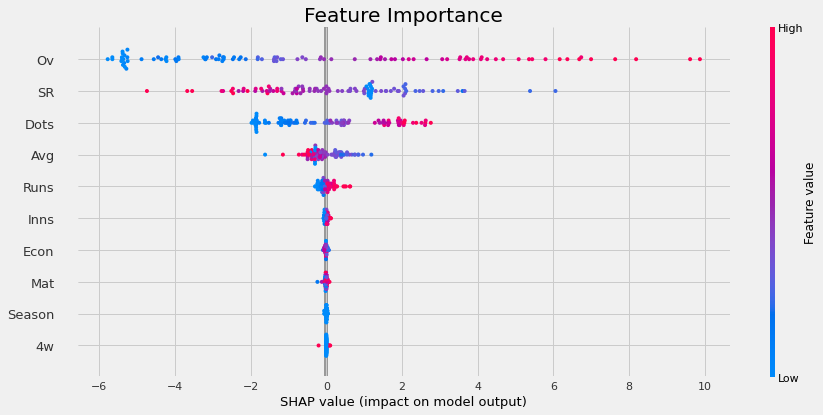

<IPython.core.display.Javascript object>

In [83]:
shap.summary_plot(shap_values, features= X_test_tr, max_display=10,plot_size=(13,6), show=False)
plt.title("Feature Importance")
plt.savefig("../images/bowling_beeswarm.png")

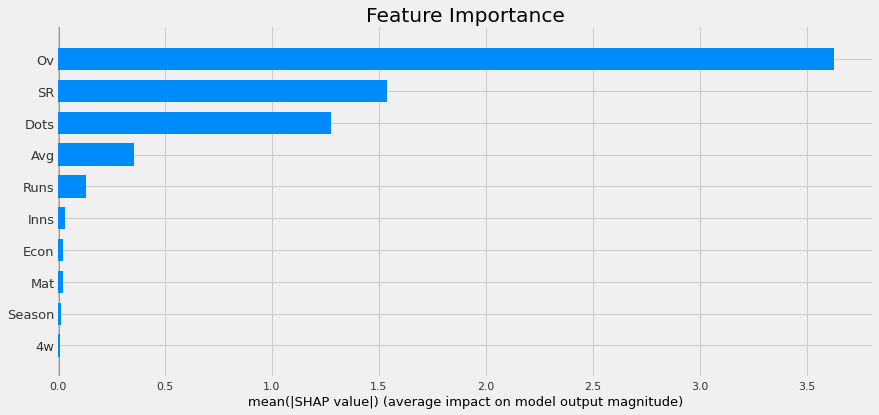

<IPython.core.display.Javascript object>

In [84]:
shap.summary_plot(shap_values, features= X_test_tr, plot_type='bar', max_display=10, plot_size=(13,6),show=False)
plt.title("Feature Importance")
plt.savefig("../images/bowling_bar.png")

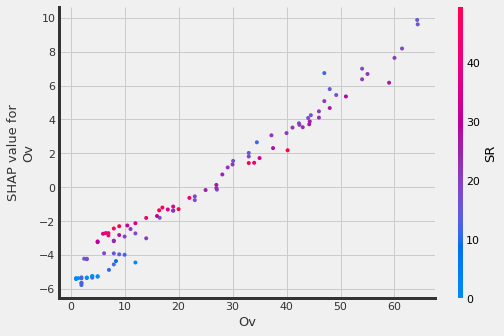

<IPython.core.display.Javascript object>

In [85]:
shap.dependence_plot("Ov",shap_values,features= X_test_tr)

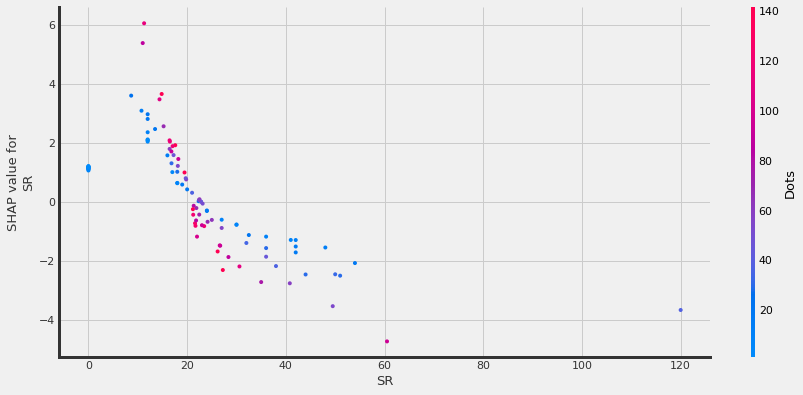

<IPython.core.display.Javascript object>

In [86]:
fig, ax = plt.subplots(figsize=(13,6))
shap.dependence_plot("SR",shap_values,features= X_test_tr, show=False, ax=ax)
plt.savefig("../images/bowling_sr.png")

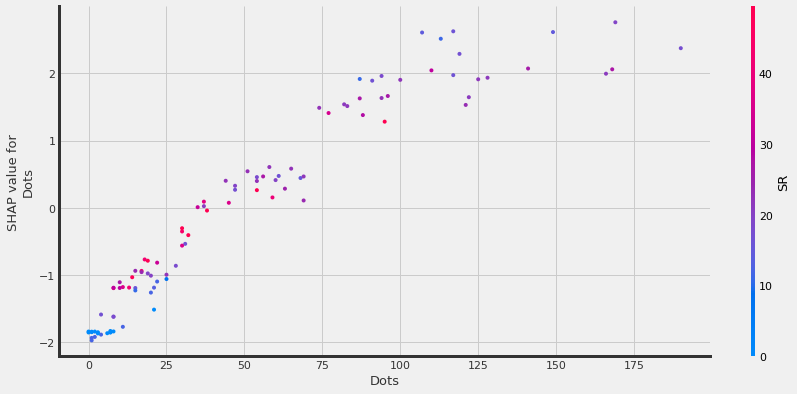

<IPython.core.display.Javascript object>

In [87]:
fig, ax = plt.subplots(figsize=(13,6))
shap.dependence_plot("Dots",shap_values,features= X_test_tr, ax=ax, show=False)
plt.savefig("../images/bowling_dots.png")

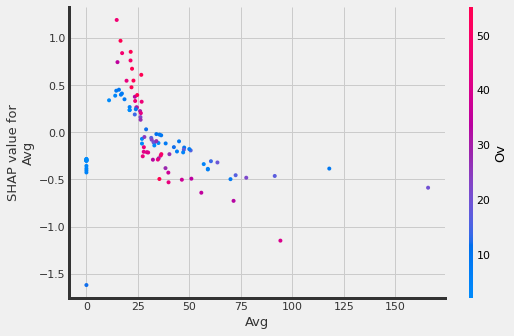

<IPython.core.display.Javascript object>

In [88]:
shap.dependence_plot("Avg",shap_values,features= X_test_tr)

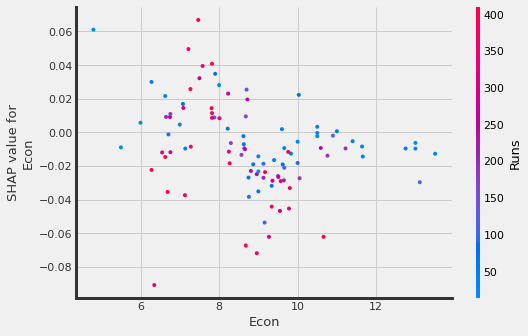

<IPython.core.display.Javascript object>

In [89]:
shap.dependence_plot("Econ",shap_values,features= X_test_tr)

### Feature Importances : 

* Ov -  This is the most important feature for predicting wickets, the reason could be that as you ball more overs the chances of getting wickets also increase compared to someone who only balls few overs.
            
* SR - Second most important feature is the Strike rate which is the average no. of balls bowled per wicket taken and it is negatively correlated with the wickets which means having a lower value of SR is good. The most interesting thing to note here is that SR is more important than the Economy rate. When people try to access a player performance, people often look at there Economy rate and If we look at the above Feature importance plot, you can see that it has very little or not effect on the no. of wickets taken which is really surprising.
        
* Dots- Another good feature is the number of dot balls a player balls. As the numbers of dot balls increase the chances of taking wickets also increases.

* Avg - Bowling average is also an important feature. It is the average number of runs conceded per wickets and it is negatively correlated with the wickets taken so having a lower Avg is good.

* Econ - Economy rate of a bowler is not so important compared to other metrics seen above if you are interested in predicting wickets. It just tell you if a bowler is economically good or not means if he gives less or more Runs per over. It doesn't say too much about a bowlers wicket taking capabilities.
